# How data transforms the prior into the posterior

Model:
\begin{equation*}
    y \sim \mathcal{N}(y^s, \sigma ^2_y),
\end{equation*}

where $y_s$ are the predictions of the structural model and $\sigma _y$ captures the fluctations of the observations around $y^s$ that we may expect due to measurement noise or uncaptured biological processes. In other words, our error model is to assume a $y^s$ independent base level noise parameterised by $\sigma ^2_y$.

In this notebook we want to understand how observations transform priors for $\sigma ^2_y$ into the final posterior distribution. This will enable us to make better informed prior probability choices for Bayesian inference.

For simplicity, let's assume the structural model is known, such that the inference is only concerned with $\sigma ^2_y$. If we then choose a inverse-gamma prior for $\sigma ^2_y$ with the probability density

\begin{equation*}
    f(\sigma ^2; \alpha, \beta ) = \frac{\beta ^{\alpha}}{\Gamma (\alpha )}\left( \frac{1}{x}\right)^{\alpha + 1}\exp \left( -\frac{\beta}{x}\right) ,
\end{equation*}

one can show that the posterior probability distribution of $\sigma ^2_y$ is also given by an inverse-gamma distribution $f(\sigma ^2; \alpha ', \beta ')$, where the parameters $\alpha '$ and $\beta '$ are functions of the observations $y^{\text{obs}}=\{ y^{\text{obs}}_1, y^{\text{obs}}_2, \ldots , y^{\text{obs}}_n\}$ and the hyperparameters of the prior $\alpha, \beta$

\begin{equation*}
    \alpha ' = \alpha + \frac{n}{2}, \quad \beta ' = \beta + \frac{\sum _{i=1}^n\left( y^{\text{obs}}_i-y^s_i\right) ^2}{2}.
\end{equation*}

It can further be derived that the resulting posterior predictive distribution is given by a Student's t distribution

\begin{equation*}
    t_{\nu }(y | \mu, \sigma ^2) = \frac{\Gamma \left( \frac{\nu + 1}{2}\right)}{\sqrt{\nu \pi}\, \Gamma \left( \frac{\nu}{2}\right)}\left( 1+\frac{(y-\mu)^2}{\nu\sigma^2}\right) ^{-\frac{\nu +1}{2}},
\end{equation*}

where the degrees of freedom are $\nu = 2\alpha '$, the mean is $\mu = y^s$, and the standard deviation is given by $\sigma ^2=\beta '/ \alpha '$.

## The true model

Let's imagine the true noise was given by 

\begin{equation*}
    \epsilon \sim \mathcal{N}(0, \sigma ^2_y = 100),
\end{equation*}

such that $y = y^s + \epsilon $. 

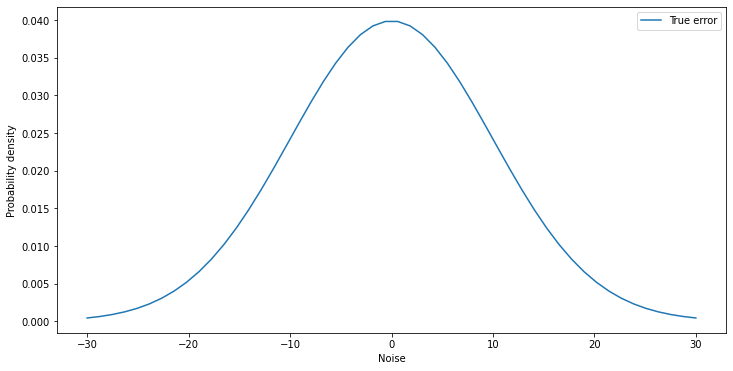

In [1]:
#
# Illustration of true noise
#

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm


# Define true sigma
sigma = 10

# Compute pdf for from range [-30, 30]
samples = np.linspace(-30, 30)
pdf = norm.pdf(samples, loc=0, scale=sigma)

# Plot PDF
# Create figure
fig = plt.figure(figsize=(12, 6))

# Plot
plt.plot(samples, pdf, label='True error')

# X and Y label
plt.xlabel('Noise')
plt.ylabel('Probability density')

# Create legend
plt.legend()

# Show plot
plt.show()

## Generating observations for the inference

We can now generate some data by drawing samples from the noise model.

In [2]:
#
# Generating data from true noise model.
#

from scipy.stats import norm

# True standard deviation
sigma = 10

# Number of observations
n = 1000

# Generate data
data = norm.rvs(loc=0, scale=sigma, size=n) 

## Defining prior distribution for $\sigma ^2_y$

Let's first define a largely non-informative prior by tuning the hyperparameters $\alpha $ and $\beta $, such that the 99th percentile of the posterior is at 5000.

99th percentile:  994.9916247342214


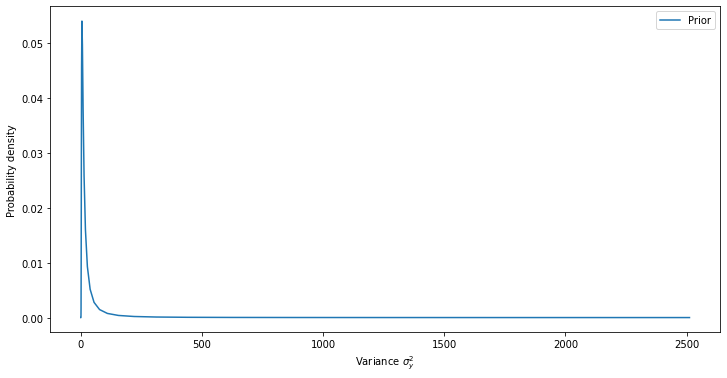

In [3]:
#
# Illustrating prior distribution for sigma ^2_y
#

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import invgamma


# Define hyperparameters
alpha = 1
beta = 10

# Compute 99th percentile
print('99th percentile: ', invgamma.ppf(.99, a=alpha, scale=beta))

# Compute pdf for from range [0, 500]
samples = np.logspace(-4, 3.4)
pdf = invgamma.pdf(samples, a=alpha, scale=beta)  # a=alpha, scale=beta

# Plot PDF
# Create figure
fig = plt.figure(figsize=(12, 6))

# Plot
plt.plot(samples, pdf, label='Prior')

# X and Y label
plt.xlabel(r'Variance $\sigma ^2_y$')
plt.ylabel('Probability density')

# Create legend
plt.legend()

# Show plot
plt.show()

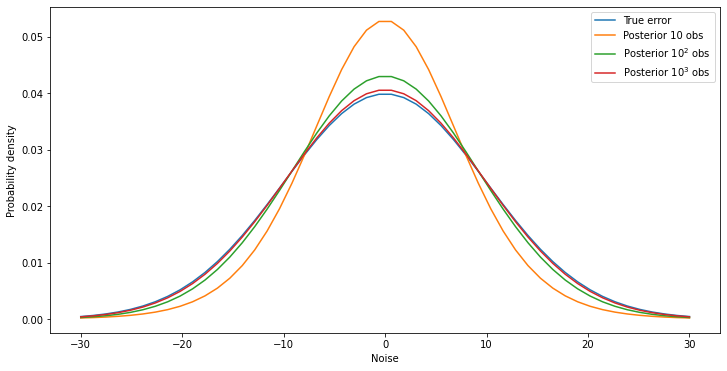

In [4]:
#
# Generate data from the true error model and illustrate posterior predictive models inferred from the data.
#
# This cell needs the previously simulated data.
#

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, t


# Define convenience functions to compute posterior parameters from data
def alpha_prime(data, alpha, beta):
    """
    Returns the posterior parameter alpha'.

    Arguments:
        data -- Noise observations.
        alpha -- Prior hyperparameter.
        beta -- Prior hyperparameter. 
    """
    # Number of observations
    n = len(data)

    return alpha + n / 2

def beta_prime(data, alpha, beta):
    """
    Returns the posterior parameter beta'.

    Arguments:
        data -- Noise observations.
        alpha -- Prior hyperparameter.
        beta -- Prior hyperparameter. 
    """
    return beta + np.sum(data ** 2) / 2

# Define prior hyperparameters
alpha = 1
beta = 10

# Compute posterior parameters for 10, 100, 1000 observations
alpha_10 = alpha_prime(data[:10], alpha, beta)
beta_10 = beta_prime(data[:10], alpha, beta)

alpha_100 = alpha_prime(data[:100], alpha, beta)
beta_100 = beta_prime(data[:100], alpha, beta)

alpha_1000 = alpha_prime(data[:1000], alpha, beta)
beta_1000 = beta_prime(data[:1000], alpha, beta)

# Define true sigma
sigma = 10

# Compute pdf of true error model for from range [-30, 30]
samples = np.linspace(-30, 30)
pdf_true = norm.pdf(samples, loc=0, scale=sigma)

# Compute pdf of posterior predictive model for from range [-30, 30]
# 10 observations
samples = np.linspace(-30, 30)
pdf_10 = t.pdf(samples, df=2*alpha_10, loc=0, scale=np.sqrt(beta_10/alpha_10))

# 100 observations
samples = np.linspace(-30, 30)
pdf_100 = t.pdf(samples, df=2*alpha_100, loc=0, scale=np.sqrt(beta_100/alpha_100))

# 1000 observations
samples = np.linspace(-30, 30)
pdf_1000 = t.pdf(samples, df=2*alpha_1000, loc=0, scale=np.sqrt(beta_1000/alpha_1000))

# Plot PDF
# Create figure
fig = plt.figure(figsize=(12, 6))

# Plot
plt.plot(samples, pdf_true, label='True error')
plt.plot(samples, pdf_10, label=r'Posterior 10 obs')
plt.plot(samples, pdf_100, label=r'Posterior $10^2$ obs')
plt.plot(samples, pdf_1000, label=r'Posterior $10^3$ obs')

# X and Y label
plt.xlabel('Noise')
plt.ylabel('Probability density')

# Create legend
plt.legend()

# Show plot
plt.show()

This was just a sanity check. We see that the predictive posterior distribution does converge to the true distribution with more and more data. Let's now see how the posterior is updated with data.

99th percentile:  994.9916247342214


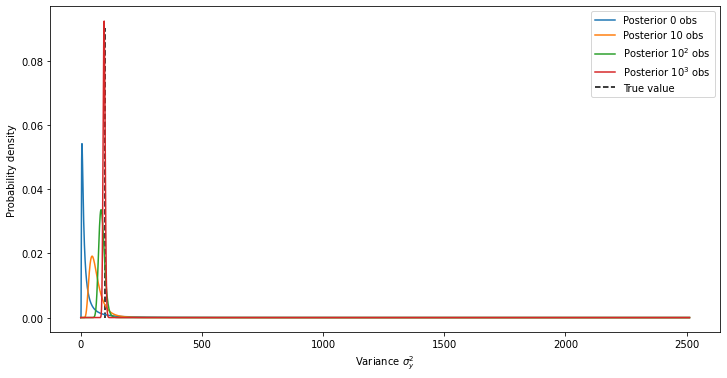

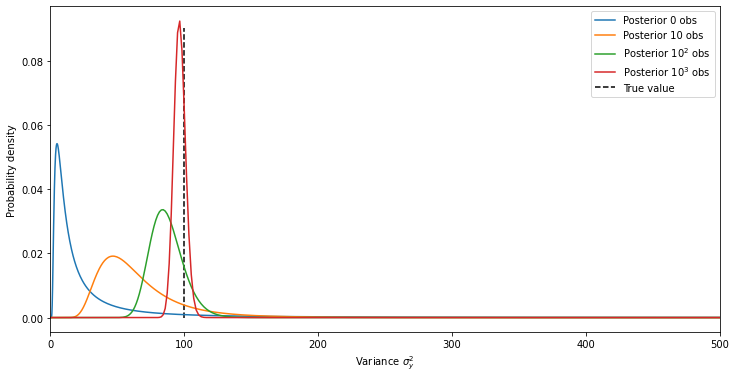

In [5]:
#
# Illustrate how observations transform prior into posterior.
#
# This cell needs the previously computed posterior parameters.
#

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import invgamma


# Define hyperparameters
alpha = 1
beta = 10

# Compute 99th percentile
print('99th percentile: ', invgamma.ppf(.99, a=alpha, scale=beta))

# Compute pdfs from range [0, 500]
samples = np.logspace(-4, 3.4, 1000)
pdf_0 = invgamma.pdf(samples, a=alpha, scale=beta)  # a=alpha, scale=beta
pdf_10 = invgamma.pdf(samples, a=alpha_10, scale=beta_10)
pdf_100 = invgamma.pdf(samples, a=alpha_100, scale=beta_100)
pdf_1000 = invgamma.pdf(samples, a=alpha_1000, scale=beta_1000)

# Plot PDF
# Create figure
fig = plt.figure(figsize=(12, 6))

# Plot
plt.vlines(x=sigma**2, ymin=0, ymax=0.09, color='black', linestyle='dashed', label='True value')
plt.plot(samples, pdf_0, label='Posterior 0 obs')
plt.plot(samples, pdf_10, label='Posterior 10 obs')
plt.plot(samples, pdf_100, label=r'Posterior $10^2$ obs')
plt.plot(samples, pdf_1000, label=r'Posterior $10^3$ obs')

# X and Y label
plt.xlabel(r'Variance $\sigma ^2_y$')
plt.ylabel('Probability density')

# Create legend
plt.legend()

# Show plot
plt.show()

# Plot PDF Zoom into interesting range
# Create figure
fig = plt.figure(figsize=(12, 6))

# Plot
plt.vlines(x=sigma**2, ymin=0, ymax=0.09, color='black', linestyle='dashed', label='True value')
plt.plot(samples, pdf_0, label='Posterior 0 obs')
plt.plot(samples, pdf_10, label='Posterior 10 obs')
plt.plot(samples, pdf_100, label=r'Posterior $10^2$ obs')
plt.plot(samples, pdf_1000, label=r'Posterior $10^3$ obs')

# X and Y label
plt.xlabel(r'Variance $\sigma ^2_y$')
plt.ylabel('Probability density')

# X limits
plt.xlim([0, 500])

# Create legend
plt.legend()

# Show plot
plt.show()


There are two things that are interesting to note about how the data shapes the posterior.

1. The posterior seems to learn very quickly that some values for $\sigma ^2_y$ are too small, even if the prior is concentrated at those values.
2. It seems to be much harder to learn from data that some values for $\sigma ^2_y$ are too large, such that it takes 1000 observations to reasonably capture the true $\sigma ^2_y$ value by the posterior distribution. Note however, that even then the distribution is biased to larger values.

To understand why that is let's have a closer look at how the data and the prior determine the posterior. The posterior distribution $\mathbb{P}(\sigma ^2_y | y^{\text{obs}}; \alpha, \beta)$ is related to the data $\epsilon^{\text{obs}}=\{ \epsilon^{\text{obs}}_1, \epsilon^{\text{obs}}_2, \ldots , \epsilon^{\text{obs}}_n\}$ and the prior $\mathbb{P}(\sigma ^2_y | \alpha, \beta)$ through Bayes' rule

\begin{equation*}
    \log \mathbb{P}(\sigma ^2_y | \epsilon^{\text{obs}}; \alpha, \beta ) =  \sum _{i=1}^n\log \mathbb{P}(\epsilon | \sigma ^2_y ) \Big| _{\epsilon=\epsilon^{\text{obs}}_i} + \log \mathbb{P}(\sigma ^2_y | \alpha, \beta ) + \text{constant},
\end{equation*}

where $\mathbb{P}(\epsilon | \sigma ^2_y )\Big| _{\epsilon=\epsilon^{\text{obs}}_i}=\mathcal{N}(0, \sigma ^2_y)\Big| _{\epsilon=\epsilon^{\text{obs}}_i}$ is the likelihood of the parameter $\sigma ^2_y$ for a fixed observation $\epsilon=\epsilon^{\text{obs}}_i $. In other words, the likelihood may also be interpreted as the probability with which the observation $\epsilon $ would be generated by the noise model $\mathcal{N}(0, \sigma ^2_y)$ for a given $\sigma ^2_y$. The prior is given by the inverse-gamma function $\mathbb{P}(\sigma ^2_y | \alpha, \beta ) = f(\sigma ^2_y | \alpha, \beta )$. Note that this means that each individual term on the right hand side of the equation assumes values in $(-\infty, 0]$. In particular, the terms assume values close to $-\infty $ if the probabilities are close to zero, and values close to zero if the probabilities are close to one. 

This shows that very small probabilities for a given $\sigma ^2_y$, either from the likelihood or the prior, will dominate the contributions to it's posterior probability, even if the remaining terms suggest high likelihood of said parameter value. This may provide the intuition that data shapes the posterior not so much by focussing on good parameter values, but rather by drastically penalising unlikely ones.

This explains why the posterior weight is so easily shifted away from small values for $\sigma ^2_y$. Any observation whose deviation from the center of the Normal distribution is larger than 4-fold of a given $\sigma ^2_y$ will immediately lead to a close to zero posterior probability of that parameter. This idea may be supported by looking at the posterior after adding observations one by one.

In [9]:
#
# Slider animation: How data shapes the posterior.
#
# This cell needs the definition of the functions alpha_prime and beta_prime.
#

from ipywidgets import *
import numpy as np
import plotly.graph_objects as go


# Define prior hyperparameters
alpha_0 = 1
beta_0 = 10

# Number observations
n = len(data)

# Define container for alpha and beta after # observations
alpha = np.empty(shape=n+1)
beta = np.empty(shape=n+1)

# Compute posterior parameters
for num_obs in range(n+1): 
    alpha[num_obs] = alpha_prime(data[:num_obs], alpha_0, beta_0)
    beta[num_obs] = beta_prime(data[:num_obs], alpha_0, beta_0)

# Define samples
samples = np.logspace(-4, 2.7, 1000)

# Define container for pdfs
pdf = np.empty(shape=(n+1, 1000))

# Compute pdfs from range [0, 500]
for num_obs in range(n+1):
    pdf[num_obs, :] = invgamma.pdf(samples, a=alpha[num_obs], scale=beta[num_obs])

# Create plot of prior
# Create figure
fig = go.FigureWidget()
fig.add_scatter()

# Plot true sigma, prior and initial posterior
# True sigma as vertical line
fig.add_trace(go.Scatter(
    x=[sigma**2, sigma**2], y=[0, 0.09], mode="lines", name='True value', 
    line = dict(color='black', dash='dash')))
fig.add_trace(go.Scatter(x=samples, y=pdf[0], mode="lines", name='Prior'))
fig.add_trace(go.Scatter(x=samples, y=pdf[0], mode="lines", name='Posterior'))

# Create layout
fig.update_layout(
    showlegend=True,
    xaxis_title=r'$\sigma ^2_y$',
    yaxis_title='Probability density',)

@interact(num_obs=(0, n, 1))
def update(num_obs=0):
    """
    Helper function to update the posterior according to the number of observations num_obs.
    """
    with fig.batch_update():
        posterior = fig.data[-1]
        posterior.y = pdf[num_obs, :]

fig

FigureWidget({
    'data': [{'type': 'scatter', 'uid': '5dde999b-f43f-4522-8943-d506aa7de5e0'},
             {…

In [7]:
import plotly.graph_objects as go
import numpy as np
from ipywidgets import interact

fig = go.FigureWidget()
fig.add_scatter()

xs=np.linspace(0, 6, 100)

@interact(a=(1.0, 4.0, 0.01), b=(0, 10.0, 0.01), color=['red', 'green', 'blue'])
def update(a=3.6, b=4.3, color='blue'):
    with fig.batch_update():
        scatt = fig.data[0]
        scatt.x=xs
        scatt.y=np.sin(a*xs-b)
        scatt.line.color=color

fig

FigureWidget({
    'data': [{'line': {'color': 'blue'},
              'type': 'scatter',
              'uid': …

In [8]:
fig.data[-1]

Scatter({
    'line': {'color': 'blue'},
    'uid': 'a97e0b46-a7dd-4735-8b22-357f629a91f6',
    'x': array([0.        , 0.06060606, 0.12121212, 0.18181818, 0.24242424, 0.3030303 ,
                0.36363636, 0.42424242, 0.48484848, 0.54545455, 0.60606061, 0.66666667,
                0.72727273, 0.78787879, 0.84848485, 0.90909091, 0.96969697, 1.03030303,
                1.09090909, 1.15151515, 1.21212121, 1.27272727, 1.33333333, 1.39393939,
                1.45454545, 1.51515152, 1.57575758, 1.63636364, 1.6969697 , 1.75757576,
                1.81818182, 1.87878788, 1.93939394, 2.        , 2.06060606, 2.12121212,
                2.18181818, 2.24242424, 2.3030303 , 2.36363636, 2.42424242, 2.48484848,
                2.54545455, 2.60606061, 2.66666667, 2.72727273, 2.78787879, 2.84848485,
                2.90909091, 2.96969697, 3.03030303, 3.09090909, 3.15151515, 3.21212121,
                3.27272727, 3.33333333, 3.39393939, 3.45454545, 3.51515152, 3.57575758,
                3.63636364, 